In [187]:
%matplotlib inline
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing
from scipy import stats as st
from scipy.optimize import minimize
from scipy.optimize import least_squares
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from sklearn.mixture import GaussianMixture as GMM

In [188]:
energy_data = pd.read_csv('energy_dataset.csv', error_bad_lines=False)
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [189]:
energy_data.isna().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [190]:
energy_data_subsample = energy_data[['generation hydro water reservoir', 'generation wind onshore', 'generation fossil oil']]
energy_data_subsample

,generation hydro water reservoir,generation wind onshore,generation fossil oil
0,1899.0,6378.0,162.0
1,1658.0,5890.0,158.0
2,1371.0,5461.0,157.0
3,779.0,5238.0,160.0
4,720.0,4935.0,156.0
...,...,...,...
35059,4836.0,3113.0,178.0
35060,3931.0,3288.0,174.0
35061,2831.0,3503.0,168.0
35062,2068.0,3586.0,163.0


In [191]:
energy_data_subsample.mean()
energy_data_subsample_clear = energy_data_subsample.fillna(energy_data.mean())

In [192]:
energy_data_subsample_clear.isna().sum()

generation hydro water reservoir    0
generation wind onshore             0
generation fossil oil               0
dtype: int64

In [193]:
n = len(energy_data_subsample_clear.index)

In [194]:
sns.set_theme(style="whitegrid")

# Generation hydro water reservoir

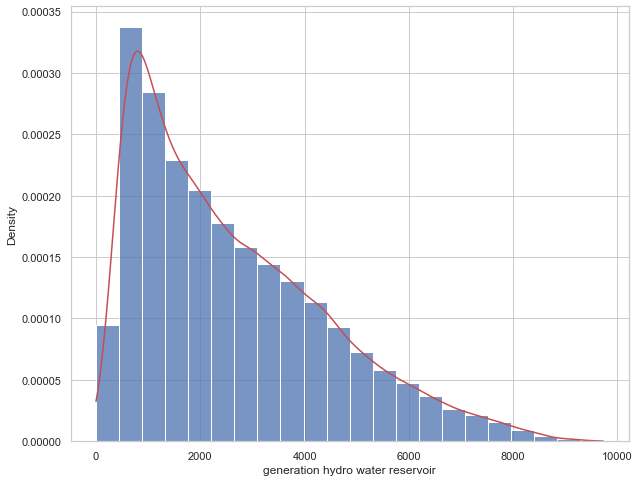

In [195]:
plt.figure(figsize=(10, 8))
ghwr_data = energy_data_subsample_clear['generation hydro water reservoir']
kernel = st.gaussian_kde(ghwr_data)
print(kernel)
min_amount, max_amount = ghwr_data.min(), ghwr_data.max()
x = np.linspace(min_amount, max_amount, len(ghwr_data))
kde_values = kernel(x)

sns.histplot(ghwr_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')
plt.plot(x, kde_values, color='r')

In [196]:
ghwr_descr = ghwr_data.describe()

print(ghwr_descr)

count    35064.000000
mean      2605.114735
std       1834.728624
min          0.000000
25%       1078.000000
50%       2165.000000
75%       3756.250000
max       9728.000000
Name: generation hydro water reservoir, dtype: float64


In [197]:
quant = ghwr_data.quantile([.1, .25, .5, .75, .95])
print(quant)

0.10     622.00
0.25    1078.00
0.50    2165.00
0.75    3756.25
0.95    6234.00
Name: generation hydro water reservoir, dtype: float64


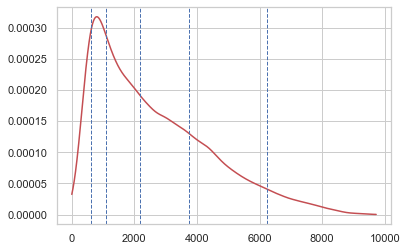

In [198]:
plt.plot(x, kde_values, color='r')
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1)

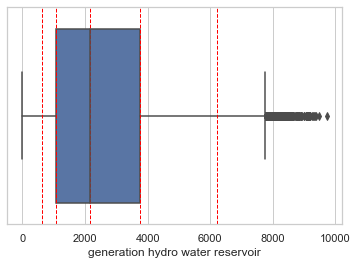

In [199]:
ax = sns.boxplot(x=ghwr_data)
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1, color='red')

In [200]:
from fitter import Fitter, get_common_distributions, get_distributions

,sumsquare_error,aic,bic,kl_div
gamma,9.355688e-08,1979.246863,-934411.109814,inf
chi2,1.356484e-07,2030.470678,-921384.949913,inf
exponpow,1.942141e-07,2009.039511,-908800.651885,inf
rayleigh,2.740004e-07,2032.523359,-896743.199635,inf
lognorm,2.861937e-07,1997.841008,-895206.074193,inf


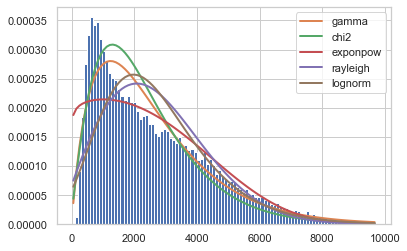

In [201]:
# 'chi', 'chi2', 'erlang', 'exponnorm','f', 'fatiguelife', 'invgamma', 'invgauss', 'johnsonsb'
f1 = Fitter(ghwr_data, distributions=get_common_distributions())

f1.fit()
f1.summary()


In [202]:
f1.get_best(method = 'sumsquare_error')

{'gamma': {'a': 1.9054548298156626,
  'loc': -0.9829232271899719,
  'scale': 1367.7037507953773}}

,sumsquare_error,aic,bic,kl_div
exponnorm,4.166661e-08,1974.205076,-962773.308814,inf
johnsonsb,4.468758e-08,2006.017247,-960308.520772,inf
fatiguelife,7.819447e-08,1978.076566,-940700.561508,inf
erlang,9.355688e-08,1979.246881,-934411.107161,inf
invgauss,1.038598e-07,1988.652384,-930747.877839,inf


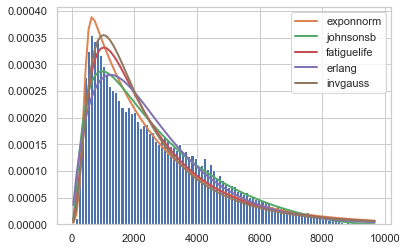

In [203]:
f2 = Fitter(ghwr_data, distributions=['chi', 'erlang', 'exponnorm','f', 'fatiguelife', 'invgamma', 'invgauss', 'johnsonsb'])
f2.fit()
f2.summary()

In [204]:
f2.get_best(method = 'sumsquare_error')

{'exponnorm': {'K': 16.802742105507946,
  'loc': 376.30328390667466,
  'scale': 132.64570643216751}}

## Maximum likelihood and Least squares method

In [205]:
params_ghwr_gamma = st.gamma.fit(ghwr_data)
x = np.linspace(np.min(ghwr_data), np.max(ghwr_data))

print(f'Maximum likelihood results: {params_ghwr_gamma}')

Maximum likelihood results: (1.9054548298156626, -0.9829232271899719, 1367.7037507953773)


In [206]:
def loss_for_least_squares_gamma(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(ghwr_data, q)
    quantiles_approx = st.gamma.ppf(q, *params)
    return quantiles - quantiles_approx

args_ls1 = least_squares(loss_for_least_squares_gamma, (1.0, 1.0, 1.0))['x']
pdf_ls1 = st.gamma.pdf(x, *args_ls1)
print(f'Least squares method results: {args_ls1}')

Least squares method results: [   1.884242    -84.44739034 1453.81821144]


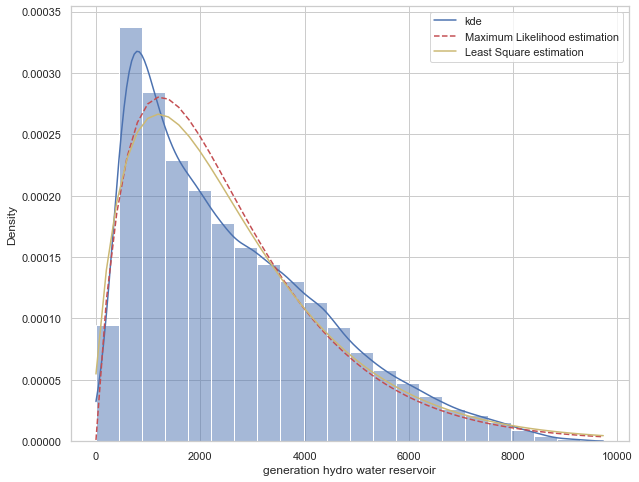

In [207]:
plt.figure(figsize=(10, 8))

sns.histplot(ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf = st.gamma.pdf(x, *params_ghwr_gamma) 

plt.plot(x, pdf, 'r--')
plt.plot(x, pdf_ls1, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

In [208]:
params_ghwr_exponnorm = st.exponnorm.fit(ghwr_data)

print(f'Maximum likelihood results: {params_ghwr_exponnorm}')

Maximum likelihood results: (16.802742105507946, 376.30328390667466, 132.64570643216751)


In [209]:
def loss_for_least_squares_exponnorm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(ghwr_data, q)
    quantiles_approx = st.exponnorm.ppf(q, *params)
    return quantiles - quantiles_approx

args_ls2 = least_squares(loss_for_least_squares_exponnorm, (1.0, 1.0, 1.0))['x']
pdf_ls2 = st.exponnorm.pdf(x, *args_ls2)
print(f'Least squares method results: {args_ls2}')

Least squares method results: [  3.71677513 665.74777739 541.81509741]


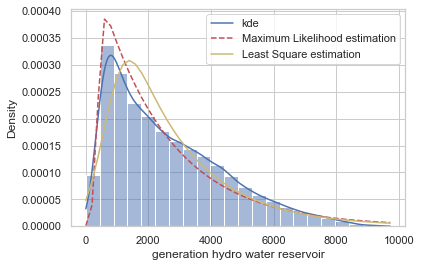

In [210]:
sns.histplot(ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf = st.exponnorm.pdf(x, *params_ghwr_exponnorm) 

plt.plot(x, pdf, 'r--')
plt.plot(x, pdf_ls2, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

In [211]:
params_ghwr_johnsonsb = st.johnsonsb.fit(ghwr_data)

print(f'Maximum likelihood results: {params_ghwr_johnsonsb}')

Maximum likelihood results: (1.1932420069028198, 0.9242514238282165, -4.449609489155438, 10054.841859706612)


In [212]:
def loss_for_least_squares_johnsonsb(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(ghwr_data, q)
    quantiles_approx = st.johnsonsb.ppf(q, *params)
    return quantiles - quantiles_approx

args_ls2 = least_squares(loss_for_least_squares_johnsonsb, (1.0, 1.0, 1.0, 1.0))['x']
pdf_ls2 = st.johnsonsb.pdf(x, *args_ls2)
print(f'Least squares method results: {args_ls2}')

Least squares method results: [8.34094041e-01 7.58374913e-01 1.43944003e+02 8.04757138e+03]


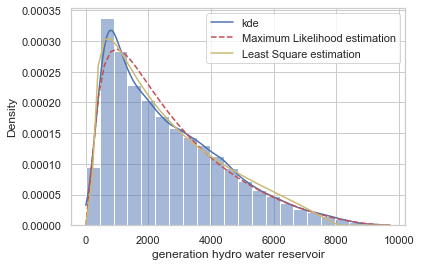

In [213]:
sns.histplot(ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf = st.johnsonsb.pdf(x, *params_ghwr_johnsonsb) 

plt.plot(x, pdf, 'r--')
plt.plot(x, pdf_ls2, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

## QQ-biplot

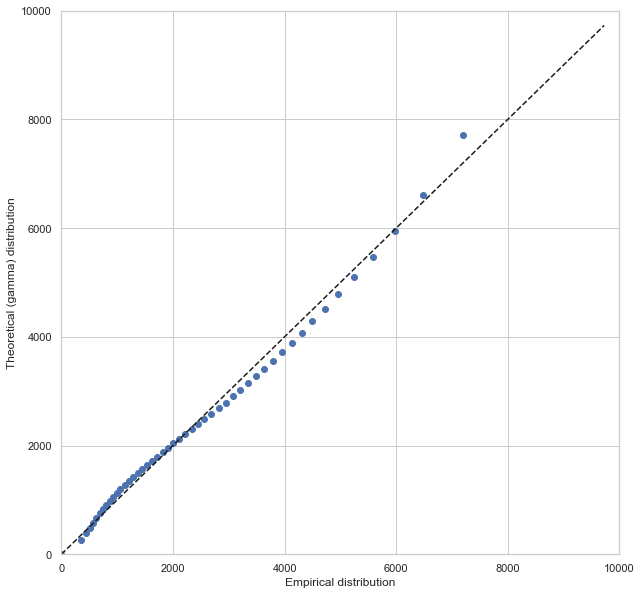

In [28]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(ghwr_data, percs)
qn_gamma = st.gamma.ppf(percs / 100.0, *params_ghwr_gamma)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (gamma) distribution')

plt.show()

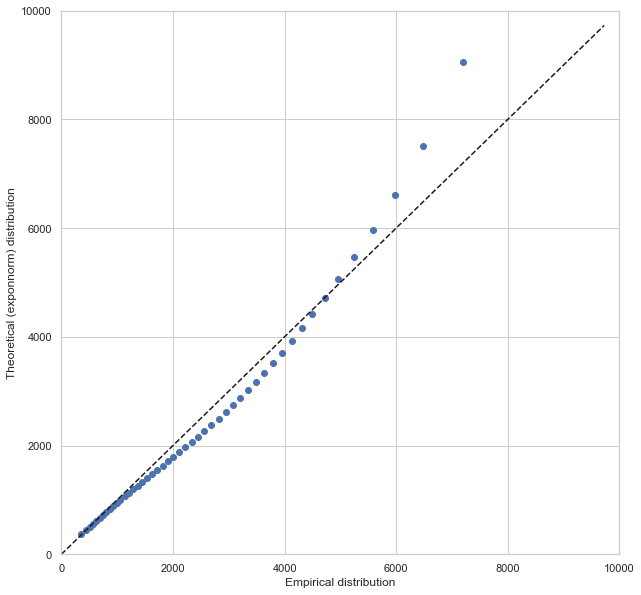

In [29]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(ghwr_data, percs)
qn_exponnorm = st.exponnorm.ppf(percs / 100.0, *params_ghwr_exponnorm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_exponnorm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (exponnorm) distribution')

plt.show()

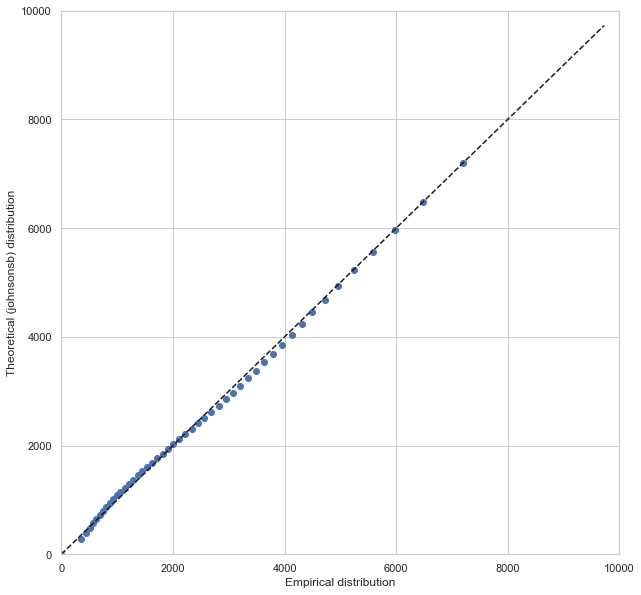

In [30]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(ghwr_data, percs)
qn_johnsonsb = st.johnsonsb.ppf(percs / 100.0, *params_ghwr_johnsonsb)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_johnsonsb, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (johnsonsb) distribution')

plt.show()

## Tests

In [31]:
# Calculation of the Kolmogorov-Smirnov test
ks1 = st.kstest(ghwr_data, 'gamma', params_ghwr_gamma)
cm1 = scipy.stats.cramervonmises(ghwr_data, 'gamma', params_ghwr_gamma)

print(ks1)
print(cm1)

KstestResult(statistic=0.04046992856341916, pvalue=2.4537023783081662e-50)
CramerVonMisesResult(statistic=19.638326499796747, pvalue=8.98746854716137e-09)


In [32]:
# Calculation of the Kolmogorov-Smirnov test 
ks2 = st.kstest(ghwr_data, 'exponnorm', params_ghwr_exponnorm)
cm2 = scipy.stats.cramervonmises(ghwr_data, 'exponnorm', params_ghwr_exponnorm)

print(ks2)
print(cm2)

KstestResult(statistic=0.0534956127426236, pvalue=1.1792212620214364e-87)
CramerVonMisesResult(statistic=36.794396265866105, pvalue=1.8800798251561446e-08)


In [33]:
# Calculation of the Kolmogorov-Smirnov test
ks3 = st.kstest(ghwr_data, 'johnsonsb', params_ghwr_johnsonsb)
cm3 = scipy.stats.cramervonmises(ghwr_data, 'johnsonsb', params_ghwr_johnsonsb)

print(ks3)
print(cm3)

KstestResult(statistic=0.02748061964248308, pvalue=1.946725173137951e-23)
CramerVonMisesResult(statistic=6.8720532546415605, pvalue=1.3568735024449552e-10)


Cutting ends

In [34]:
def cut_ends(feature):

    q_1, q_3 = np.percentile(feature, [25, 75])
    dfce = q_3 - q_1
    bottom_border, top_border = q_1 - 1.5*dfce, q_3 + 1.5*dfce
    feature = feature[feature > bottom_border]
    feature = feature[feature < top_border]

    return feature

In [35]:
cutting_ghwr_data = cut_ends(ghwr_data)

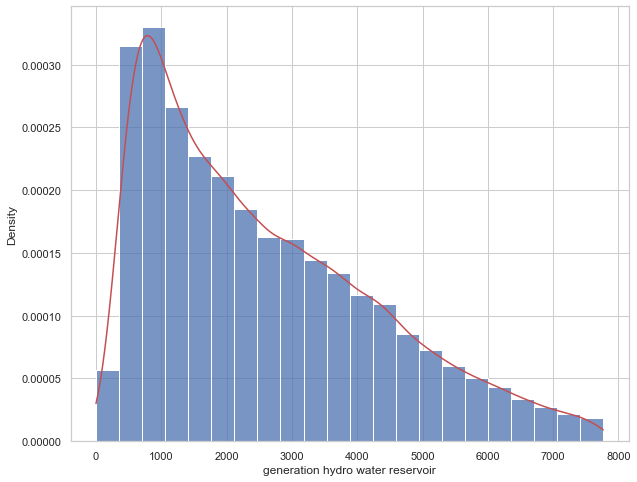

In [36]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_ghwr_data)
print(kernel)
min_amount, max_amount = cutting_ghwr_data.min(), cutting_ghwr_data.max()
x = np.linspace(min_amount, max_amount, len(cutting_ghwr_data))
kde_values = kernel(x)

sns.histplot(cutting_ghwr_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')
plt.plot(x, kde_values, color='r')

,sumsquare_error,aic,bic,kl_div
gamma,1.269986e-07,1881.992587,-914290.712314,0.048829
chi2,1.349378e-07,1887.385134,-912185.352137,0.050386
rayleigh,3.464231e-07,1886.479140,-879460.169942,0.104798
norm,4.962457e-07,1902.936535,-866981.442202,0.145674
expon,5.458898e-07,1877.396021,-863671.028845,0.374353


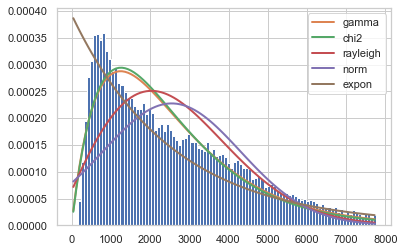

In [37]:
# 'chi', 'chi2', 'erlang', 'exponnorm','f', 'fatiguelife', 'invgamma', 'invgauss', 'johnsonsb'
f1_c = Fitter(cutting_ghwr_data, distributions=get_common_distributions())

f1_c.fit()
f1_c.summary()

In [40]:
f1_c.get_best(method = 'sumsquare_error')

{'gamma': {'a': 1.953736402839028,
  'loc': -1.1217648183711937,
  'scale': 1305.2909943333118}}

,sumsquare_error,aic,bic,kl_div
exponnorm,6.173114e-08,1895.326257,-939337.281491,0.019004
johnsonsb,6.282774e-08,1871.397758,-938715.467685,0.026602
fatiguelife,1.055001e-07,1898.717091,-920730.008118,0.027775
erlang,1.269986e-07,1881.992583,-914290.711207,0.048829
invgamma,2.039825e-07,1894.285733,-897838.343043,0.067704


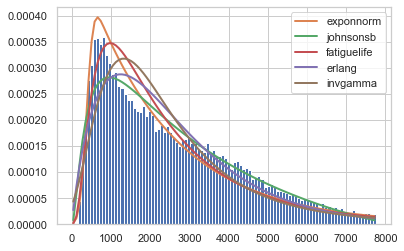

In [41]:
f2_c = Fitter(cutting_ghwr_data, distributions=['chi', 'erlang', 'exponnorm','f', 'fatiguelife', 'invgamma', 'invgauss', 'johnsonsb'])
f2_c.fit()
f2_c.summary()

In [42]:
f2_c.get_best(method = 'sumsquare_error')

{'exponnorm': {'K': 15.982543588396112,
  'loc': 380.9267003996439,
  'scale': 135.65712893542826}}

In [43]:
params_cutting_ghwr_gamma = st.gamma.fit(cutting_ghwr_data)
x = np.linspace(np.min(cutting_ghwr_data), np.max(cutting_ghwr_data))

print(f'Maximum likelihood results: {params_cutting_ghwr_gamma}')

Maximum likelihood results: (1.953736402839028, -1.1217648183711937, 1305.2909943333118)


In [44]:
params_cutting_ghwr_exponnorm = st.exponnorm.fit(cutting_ghwr_data)

print(f'Maximum likelihood results: {params_cutting_ghwr_exponnorm}')

Maximum likelihood results: (15.982543588396112, 380.9267003996439, 135.65712893542826)


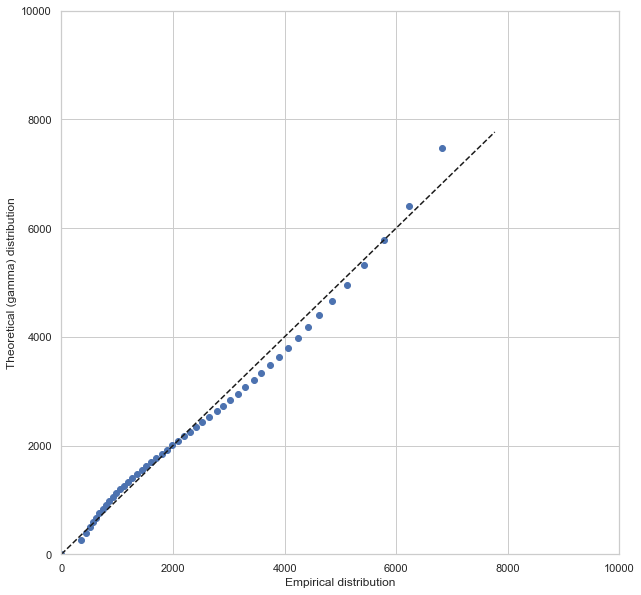

In [45]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_ghwr_data, percs)
qn_gamma = st.gamma.ppf(percs / 100.0, *params_cutting_ghwr_gamma)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (gamma) distribution')

plt.show()

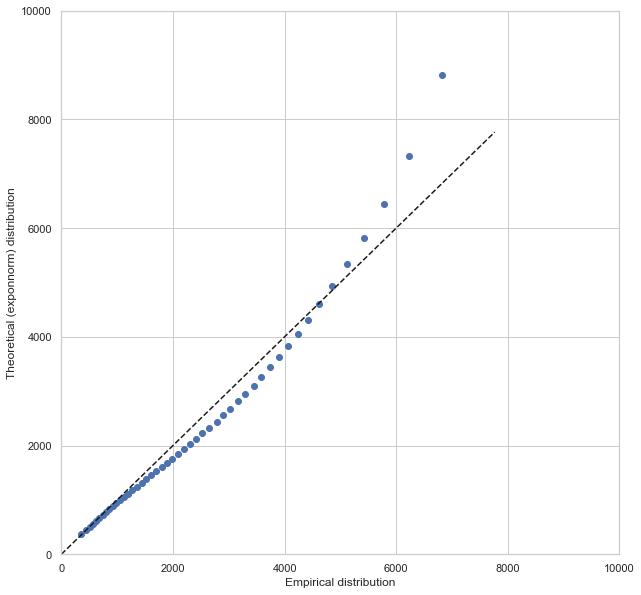

In [46]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_ghwr_data, percs)
qn_exponnorm = st.exponnorm.ppf(percs / 100.0, *params_cutting_ghwr_exponnorm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_exponnorm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (exponnorm) distribution')

plt.show()

In [47]:
# Calculation of the Kolmogorov-Smirnov test
ks1_c = st.kstest(cutting_ghwr_data, 'gamma', params_cutting_ghwr_gamma)
cm1_c = scipy.stats.cramervonmises(cutting_ghwr_data, 'gamma', params_cutting_ghwr_gamma)

print(ks1_c)
print(cm1_c)

KstestResult(statistic=0.04072663932167875, pvalue=1.779249927757078e-50)
CramerVonMisesResult(statistic=22.055314256283165, pvalue=4.431098377111198e-09)


In [48]:
# Calculation of the Kolmogorov-Smirnov test
ks2_c = st.kstest(cutting_ghwr_data, 'exponnorm', params_cutting_ghwr_exponnorm)
cm2_c = scipy.stats.cramervonmises(cutting_ghwr_data, 'exponnorm', params_cutting_ghwr_exponnorm)

print(ks2_c)
print(cm2_c)

KstestResult(statistic=0.057303832067744365, pvalue=1.5272266603630092e-99)
CramerVonMisesResult(statistic=42.63238811335339, pvalue=4.758553440176172e-09)


Yeo-Johnson

In [160]:
# Yeo Johnson transformation

ghwr_data_tr = st.yeojohnson(ghwr_data, lmbda=0)

In [161]:
cutting_ghwr_data_tr = cut_ends(ghwr_data_tr)

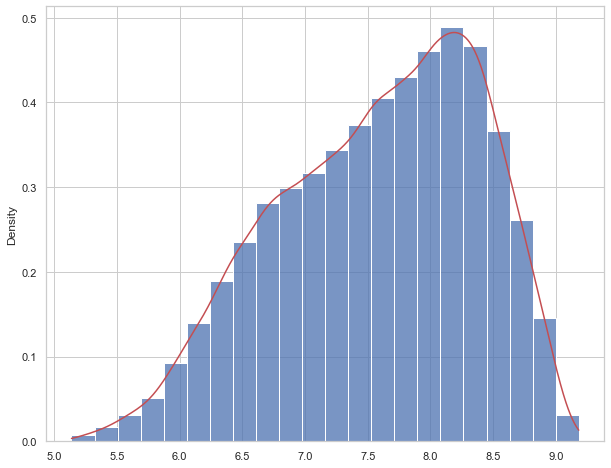

In [162]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_ghwr_data_tr)
print(kernel)
min_amount, max_amount = min(cutting_ghwr_data_tr), max(cutting_ghwr_data_tr)
x = np.linspace(min_amount, max_amount, len(cutting_ghwr_data_tr))
kde_values = kernel(x)

sns.histplot(cutting_ghwr_data_tr, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')
plt.plot(x, kde_values, color='r')

In [52]:
params_cutting_ghwr_norm = st.norm.fit(cutting_ghwr_data_tr)
x = np.linspace(np.min(cutting_ghwr_data_tr), np.max(cutting_ghwr_data_tr))

print(f'Maximum likelihood results: {params_cutting_ghwr_norm}')

Maximum likelihood results: (7.5820586901720795, 0.8060902064495766)


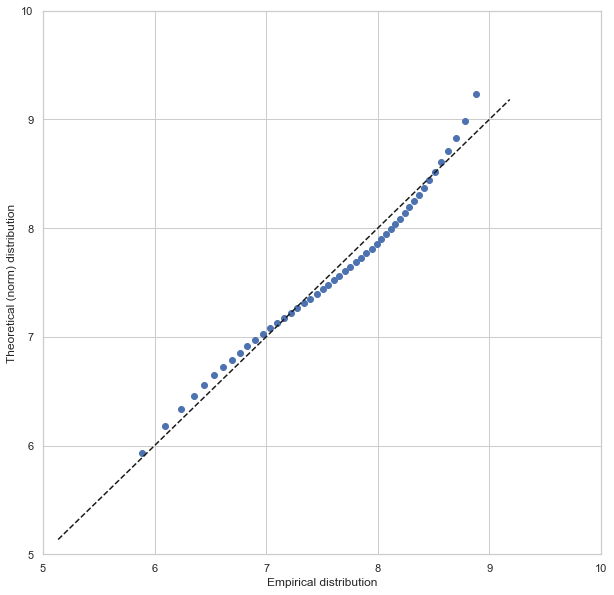

In [53]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_ghwr_data_tr, percs)
qn_norm = st.norm.ppf(percs / 100.0, *params_cutting_ghwr_norm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(5, 10)
plt.ylim(5, 10)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

# Generation wind onshore

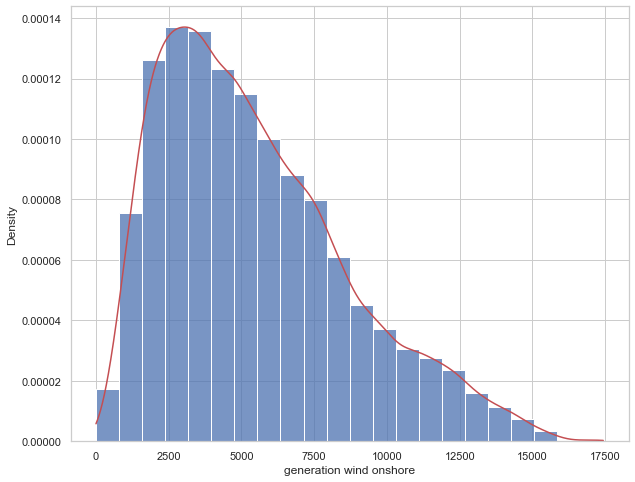

In [54]:
plt.figure(figsize=(10, 8))
gwo_data = energy_data_subsample_clear['generation wind onshore']
kernel = st.gaussian_kde(gwo_data)
print(kernel)
min_amount, max_amount = gwo_data.min(), gwo_data.max()
x = np.linspace(min_amount, max_amount, len(gwo_data))
kde_values = kernel(x)

sns.histplot(gwo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')
plt.plot(x, kde_values, color='r')

In [55]:
gwo_descr = gwo_data.describe()

print(gwo_descr)

count    35064.000000
mean      5464.479769
std       3212.866588
min          0.000000
25%       2933.750000
50%       4850.500000
75%       7397.000000
max      17436.000000
Name: generation wind onshore, dtype: float64


In [56]:
quant = gwo_data.quantile([.1, .25, .5, .75, .95])
print(quant)

0.10     1809.00
0.25     2933.75
0.50     4850.50
0.75     7397.00
0.95    11874.85
Name: generation wind onshore, dtype: float64


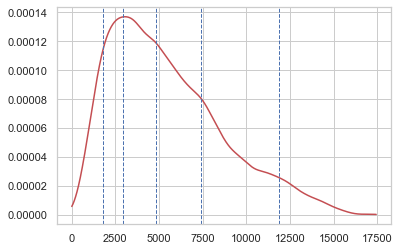

In [57]:
plt.plot(x, kde_values, color='r')
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1)

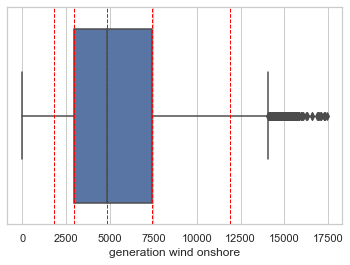

In [58]:
ax = sns.boxplot(x=gwo_data)
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1, color='red')

,sumsquare_error,aic,bic,kl_div
gamma,4.405781e-09,2083.417095,-1.041554e+06,inf
rayleigh,1.883992e-08,2109.347011,-9.906148e+05,inf
chi2,3.202847e-08,2136.671004,-9.719978e+05,inf
norm,5.198683e-08,2150.730376,-9.550245e+05,inf
cauchy,7.204375e-08,2123.218054,-9.435837e+05,inf


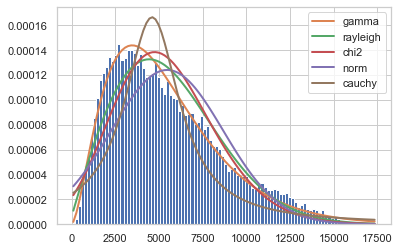

In [59]:
f1 = Fitter(gwo_data, distributions=get_common_distributions())

f1.fit()
f1.summary()

In [60]:
f1.get_best(method = 'sumsquare_error')

{'gamma': {'a': 2.7381722406202487,
  'loc': -24.243996523196554,
  'scale': 2004.5210079806645}}

,sumsquare_error,aic,bic,kl_div
johnsonsb,1.860430e-09,2105.384113,-1.071773e+06,inf
skewnorm,2.338700e-09,2085.862554,-1.063761e+06,inf
erlang,4.405781e-09,2083.417094,-1.041554e+06,inf
gamma,4.405781e-09,2083.417095,-1.041554e+06,inf
geninvgauss,4.405851e-09,2085.419684,-1.041543e+06,inf


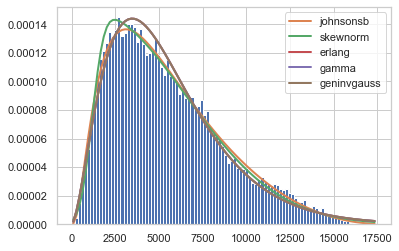

In [61]:
# 'beta', 'betaprime', 'burr', 'erlang', 'exponnorm', 'exponpow', 'f', 'gamma', 'geninvgauss', 'gausshyper', 
# 'genlogistic', 'gumbel_r', 'invgamma', 'johnsonsb', 'kstwobign', 'maxwell', moyal', 'nakagami', 'skewnorm'
f2 = Fitter(gwo_data, distributions=['beta', 'betaprime', 'burr', 'erlang', 'exponnorm', 'exponpow', 'f', 'gamma', 'geninvgauss', 'gausshyper', 'genlogistic', 'gumbel_r', 'invgamma', 'johnsonsb', 'kstwobign', 'maxwell', 'moyal', 'nakagami', 'skewnorm'])
f2.fit()
f2.summary()

In [62]:
f2.get_best(method = 'sumsquare_error')

{'johnsonsb': {'a': 1.1422162115146333,
  'b': 1.0876604758305546,
  'loc': -51.65726804772367,
  'scale': 19024.14356495395}}

## Maximum likelihood and Least squares method

In [214]:
params_gwo_gamma = st.gamma.fit(gwo_data)
x = np.linspace(np.min(gwo_data), np.max(gwo_data))

print(f'Maximum likelihood results: {params_gwo_gamma}')

Maximum likelihood results: (2.7381722406202487, -24.243996523196554, 2004.5210079806645)


In [216]:
def loss_for_least_squares_gamma(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gwo_data, q)
    quantiles_approx = st.gamma.ppf(q, *params)
    return quantiles - quantiles_approx

args_ls1 = least_squares(loss_for_least_squares_gamma, (1.0, 1.0, 1.0))['x']
pdf_ls1 = st.gamma.pdf(x, *args_ls1)
print(f'Least squares method results: {args_ls1}')

Least squares method results: [   2.67896881 -101.08565702 2104.85261596]


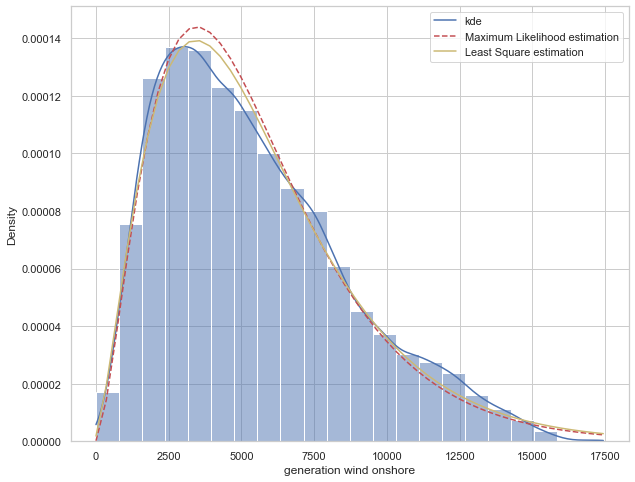

In [65]:
plt.figure(figsize=(10, 8))

sns.histplot(gwo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')

pdf = st.gamma.pdf(x, *params_gwo_gamma) 

plt.plot(x, pdf, 'r--')
plt.plot(x, pdf_ls1, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

In [66]:
params_gwo_johnsonsb = st.johnsonsb.fit(gwo_data)
print(f'Maximum likelihood results: {params_gwo_johnsonsb}')

Maximum likelihood results: (1.1422162115146333, 1.0876604758305546, -51.65726804772367, 19024.14356495395)


In [217]:
def loss_for_least_squares_johnsonsb(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gwo_data, q)
    quantiles_approx = st.johnsonsb.ppf(q, *params)
    return quantiles - quantiles_approx

args_ls2 = least_squares(loss_for_least_squares_johnsonsb, (1.0, 1.0, 1.0, 1.0))['x']
pdf_ls2 = st.johnsonsb.pdf(x, *args_ls2)
print(f'Least squares method results: {args_ls2}')

Least squares method results: [ 1.46071649e+00  1.17313496e+00 -1.54512783e+02  2.23314202e+04]


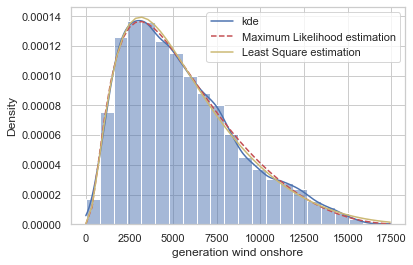

In [68]:
sns.histplot(gwo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')

pdf = st.johnsonsb.pdf(x, *params_gwo_johnsonsb) 

plt.plot(x, pdf, 'r--')
plt.plot(x, pdf_ls2, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

## QQ-biplot

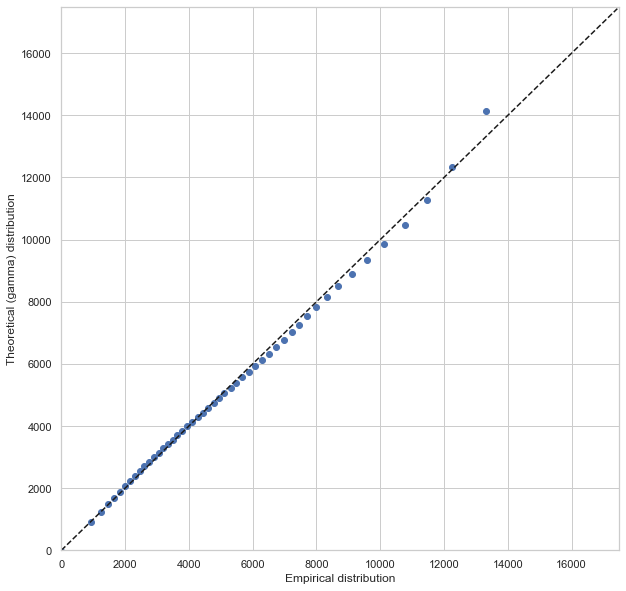

In [69]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gwo_data, percs)
qn_gamma = st.gamma.ppf(percs / 100.0, *params_gwo_gamma)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 17500)
plt.ylim(0, 17500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (gamma) distribution')

plt.show()

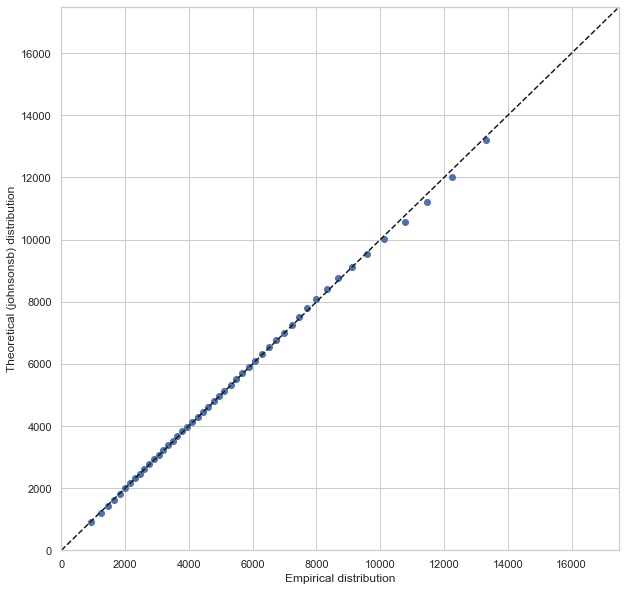

In [70]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gwo_data, percs)
qn_johnsonsb = st.johnsonsb.ppf(percs / 100.0, *params_gwo_johnsonsb)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_johnsonsb, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 17500)
plt.ylim(0, 17500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (johnsonsb) distribution')

plt.show()

## Tests

In [71]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
ks1 = st.kstest(gwo_data, 'gamma', params_gwo_gamma)
cm1 = scipy.stats.cramervonmises(gwo_data, 'gamma', params_gwo_gamma)

print(ks1)
print(cm1)

KstestResult(statistic=0.018142481996139437, pvalue=1.8640521055850942e-10)
CramerVonMisesResult(statistic=3.877186512605061, pvalue=1.0064272748522285e-09)


In [72]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
ks2 = st.kstest(gwo_data, 'johnsonsb', params_gwo_johnsonsb)
cm2 = scipy.stats.cramervonmises(gwo_data, 'johnsonsb', params_gwo_johnsonsb)

print(ks2)
print(cm2)

KstestResult(statistic=0.007733720579730319, pvalue=0.030003916051986046)
CramerVonMisesResult(statistic=0.413745921555527, pvalue=0.06647110669378131)


Cutting

In [73]:
cutting_gwo_data = cut_ends(gwo_data)

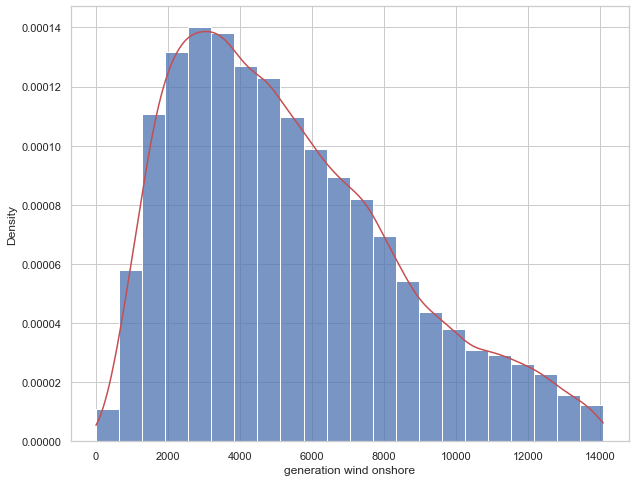

In [74]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_gwo_data)
print(kernel)
min_amount, max_amount = cutting_gwo_data.min(), cutting_gwo_data.max()
x = np.linspace(min_amount, max_amount, len(cutting_gwo_data))
kde_values = kernel(x)

sns.histplot(cutting_gwo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')
plt.plot(x, kde_values, color='r')

,sumsquare_error,aic,bic,kl_div
gamma,7.091632e-09,1994.788206,-1.013379e+06,0.009342
chi2,7.091839e-09,1994.779671,-1.013378e+06,0.009345
rayleigh,2.167333e-08,1988.198012,-9.746417e+05,0.026475
norm,6.251579e-08,1998.993702,-9.378997e+05,0.079203
cauchy,9.321431e-08,2046.180514,-9.240440e+05,0.104832


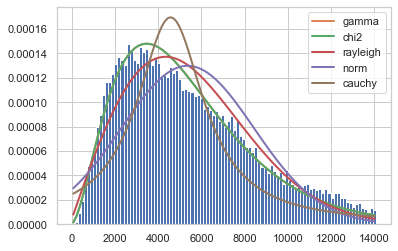

In [75]:
f1_c = Fitter(cutting_gwo_data, distributions=get_common_distributions())

f1_c.fit()
f1_c.summary()

In [76]:
f1_c.get_best(method = 'sumsquare_error')

{'gamma': {'a': 2.846015230092835,
  'loc': -42.04986883077718,
  'scale': 1898.5917351871904}}

,sumsquare_error,aic,bic,kl_div
johnsonsb,3.507625e-09,1987.720191,-1.037785e+06,0.005948
skewnorm,3.908793e-09,1990.211904,-1.034040e+06,0.006912
geninvgauss,7.091567e-09,1996.788746,-1.013369e+06,0.009342
erlang,7.091632e-09,1994.788207,-1.013379e+06,0.009342
gamma,7.091632e-09,1994.788206,-1.013379e+06,0.009342


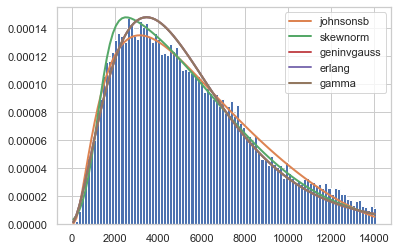

In [77]:
f2_c = Fitter(cutting_gwo_data, distributions=['beta', 'betaprime', 'burr', 'erlang', 'exponnorm', 'exponpow', 'f', 'gamma', 'geninvgauss', 'gausshyper', 'genlogistic', 'gumbel_r', 'invgamma', 'johnsonsb', 'kstwobign', 'maxwell', 'moyal', 'nakagami', 'skewnorm'])
f2_c.fit()
f2_c.summary()

In [78]:
f2_c.get_best(method = 'sumsquare_error')

{'johnsonsb': {'a': 0.8976902261622016,
  'b': 1.0367829618165527,
  'loc': -32.645235444220894,
  'scale': 16575.797223662117}}

In [79]:
params_cutting_gwo_gamma = st.gamma.fit(cutting_gwo_data)
x = np.linspace(np.min(cutting_gwo_data), np.max(cutting_gwo_data))

print(f'Maximum likelihood results: {params_cutting_gwo_gamma}')

Maximum likelihood results: (2.846015230092835, -42.04986883077718, 1898.5917351871904)


In [80]:
params_cutting_gwo_johnsonsb = st.johnsonsb.fit(cutting_gwo_data)
x = np.linspace(np.min(cutting_gwo_data), np.max(cutting_gwo_data))

print(f'Maximum likelihood results: {params_cutting_gwo_johnsonsb}')

Maximum likelihood results: (0.8976902261622016, 1.0367829618165527, -32.645235444220894, 16575.797223662117)


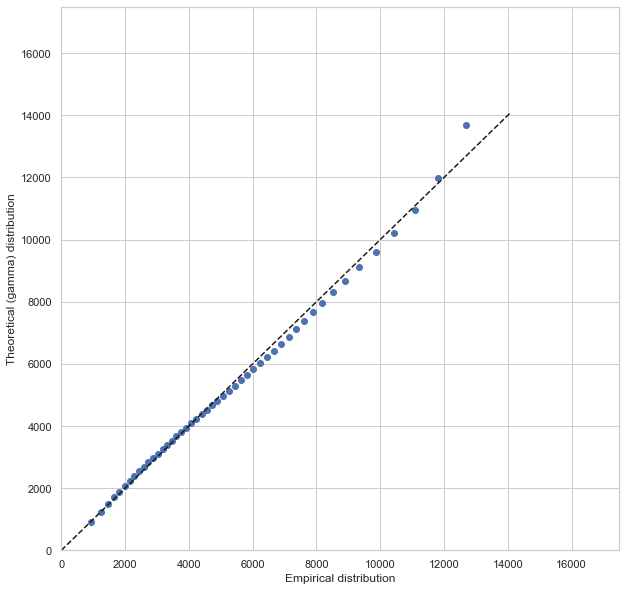

In [81]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_gwo_data, percs)
qn_gamma = st.gamma.ppf(percs / 100.0, *params_cutting_gwo_gamma)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 17500)
plt.ylim(0, 17500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (gamma) distribution')

plt.show()

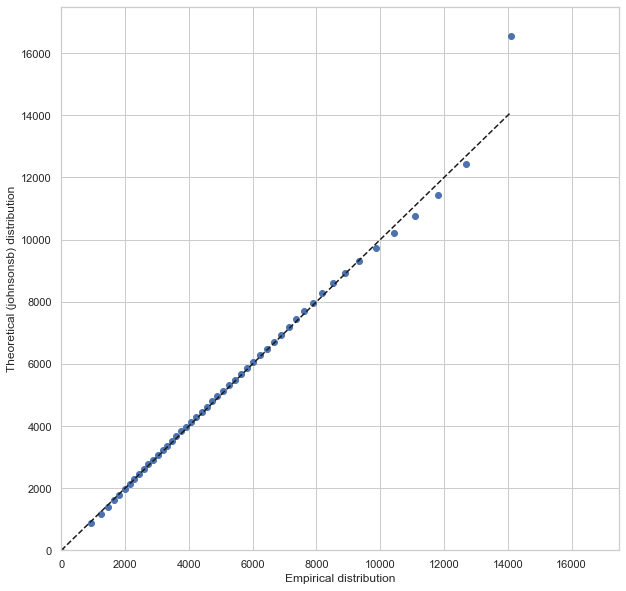

In [83]:
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_gwo_data, percs)
qn_johnsonsb = st.johnsonsb.ppf(percs / 100.0, *params_cutting_gwo_johnsonsb)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_johnsonsb, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 17500)
plt.ylim(0, 17500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (johnsonsb) distribution')

plt.show()

In [84]:
# Calculation of the Kolmogorov-Smirnov test
ks1 = st.kstest(cutting_gwo_data, 'gamma', params_cutting_gwo_gamma)
cm1 = scipy.stats.cramervonmises(cutting_gwo_data, 'gamma', params_cutting_gwo_gamma)

print(ks1)
print(cm1)

KstestResult(statistic=0.022700541636366145, pvalue=5.865950233029698e-16)
CramerVonMisesResult(statistic=5.638335095164239, pvalue=4.933051744870909e-10)


In [85]:
# Calculation of the Kolmogorov-Smirnov test
ks2 = st.kstest(cutting_gwo_data, 'johnsonsb', params_cutting_gwo_johnsonsb)
cm2 = scipy.stats.cramervonmises(cutting_gwo_data, 'johnsonsb', params_cutting_gwo_johnsonsb)

print(ks2)
print(cm2)

KstestResult(statistic=0.011205425934731839, pvalue=0.0003273549076737385)
CramerVonMisesResult(statistic=1.2891091518312066, pvalue=0.0005248723016764156)


In [173]:
# Yeo Johnson transformation

gwo_data_tr = st.yeojohnson(gwo_data, lmbda=0)

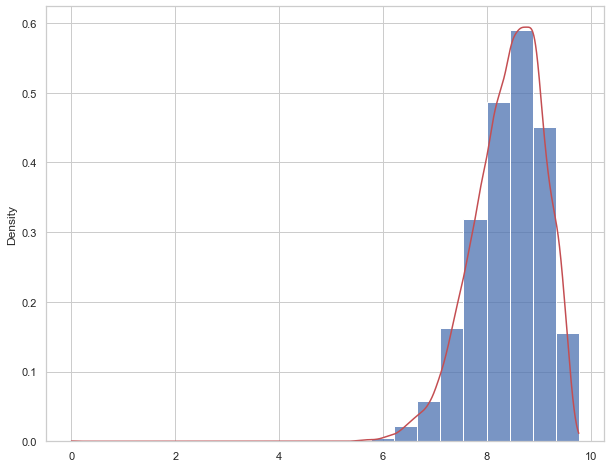

In [174]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(gwo_data_tr)
print(kernel)
min_amount, max_amount = gwo_data_tr.min(), gwo_data_tr.max()
x = np.linspace(min_amount, max_amount, len(gwo_data_tr))
kde_values = kernel(x)

sns.histplot(gwo_data_tr, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')
plt.plot(x, kde_values, color='r')

In [175]:
cutting_gwo_data_tr = cut_ends(gwo_data_tr)

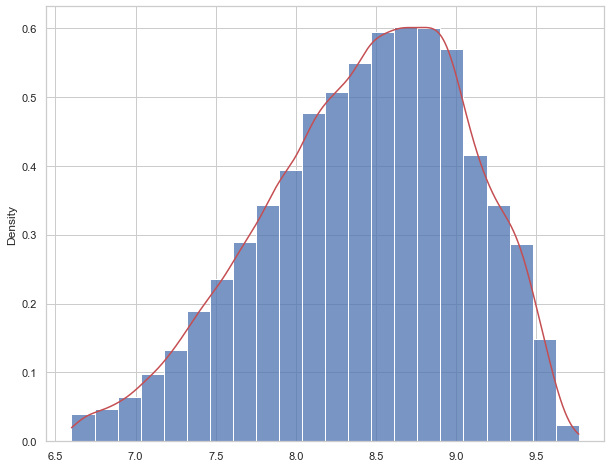

In [176]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_gwo_data_tr)
print(kernel)
min_amount, max_amount = cutting_gwo_data_tr.min(), cutting_gwo_data_tr.max()
x = np.linspace(min_amount, max_amount, len(cutting_gwo_data_tr))
kde_values = kernel(x)

sns.histplot(cutting_gwo_data_tr, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')
plt.plot(x, kde_values, color='r')

In [167]:
params_cutting_gwo_norm = st.norm.fit(cutting_gwo_data_tr)
x = np.linspace(np.min(cutting_gwo_data_tr), np.max(cutting_gwo_data_tr))

print(f'Maximum likelihood results: {params_cutting_gwo_norm}')

Maximum likelihood results: (5361.371140463903, 3073.9935135160304)


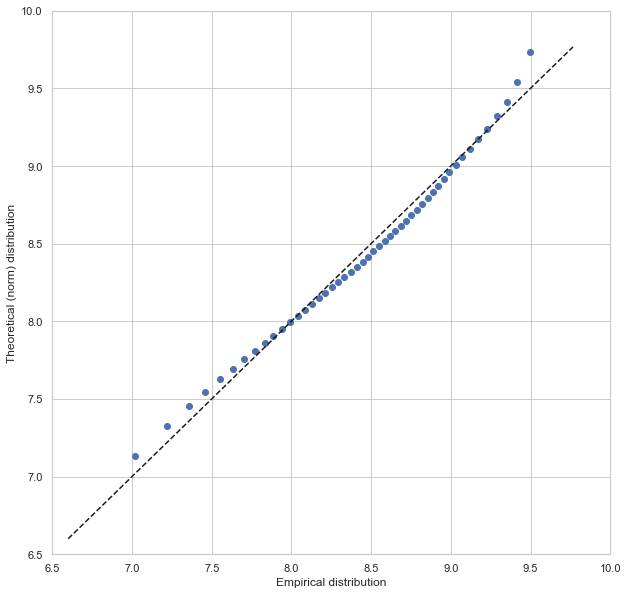

In [91]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_gwo_data_tr, percs)
qn_norm = st.norm.ppf(percs / 100.0, *params_cutting_gwo_norm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(6.5, 10)
plt.ylim(6.5, 10)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

In [92]:
# Calculation of the Kolmogorov-Smirnov test
loc, scale = params_cutting_gwo_norm
n = scipy.stats.norm(loc=loc, scale=scale)

ks = st.kstest(cutting_gwo_data_tr, n.cdf)
cm = scipy.stats.cramervonmises(cutting_gwo_data_tr, n.cdf)

print(ks)
print(cm)

KstestResult(statistic=0.0444668281133499, pvalue=4.864910306988111e-60)
CramerVonMisesResult(statistic=22.80226646544296, pvalue=7.51390427655707e-09)


# Generation fossil oil

In [101]:
gfo_data
n = len(energy_data_subsample_clear.index)

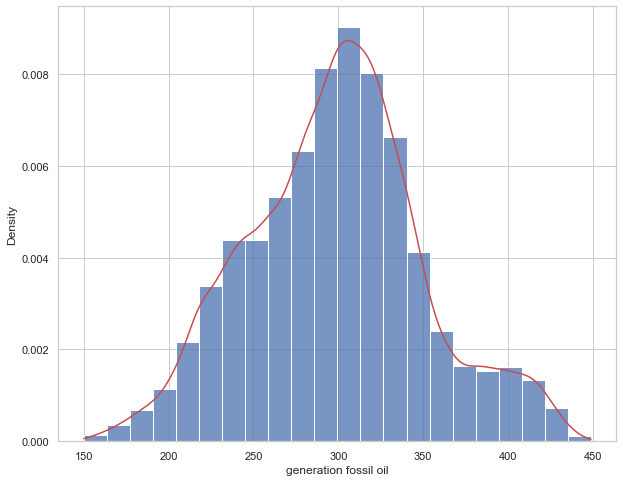

In [102]:
plt.figure(figsize=(10, 8))
gfo_data = energy_data_subsample_clear['generation fossil oil']

gfo_data = gfo_data.loc[(gfo_data >= 150) & (gfo_data < 500)]

kernel = st.gaussian_kde(gfo_data)
print(kernel)
min_amount, max_amount = gfo_data.min(), gfo_data.max()
x = np.linspace(min_amount, max_amount, len(gfo_data))
kde_values = kernel(x)


sns.histplot(gfo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')
plt.plot(x, kde_values, color='r')

In [103]:
gfo_descr = gfo_data.describe()

print(gfo_descr)

count    35015.000000
mean       298.563761
std         52.117710
min        150.000000
25%        263.000000
50%        300.000000
75%        330.000000
max        449.000000
Name: generation fossil oil, dtype: float64


In [104]:
quant = gfo_data.quantile([.1, .25, .5, .75, .95])

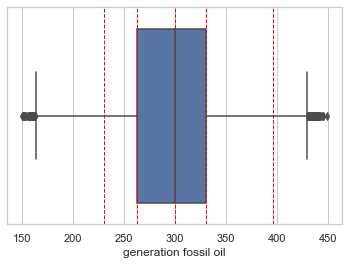

In [105]:
ax = sns.boxplot(x=gfo_data)
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1, color='red')

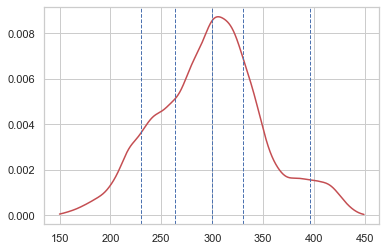

In [106]:
plt.plot(x, kde_values, color='r')
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1)

,sumsquare_error,aic,bic,kl_div
norm,0.000057,1252.776177,-708823.433163,0.027247
lognorm,0.000060,1255.893029,-706904.185175,0.026328
gamma,0.000060,1255.938255,-706804.794459,0.026347
chi2,0.000068,1259.717079,-702331.956142,0.027321
cauchy,0.000121,1273.020059,-682171.148858,0.060421


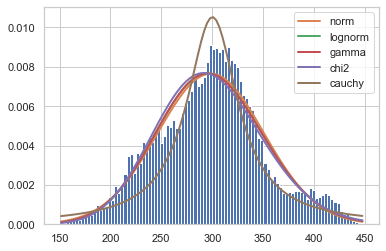

In [107]:
f1 = Fitter(gfo_data, distributions=get_common_distributions())

f1.fit()
f1.summary()

In [108]:
f1.get_best(method = 'sumsquare_error')

{'norm': {'loc': 298.5637605594178, 'scale': 52.11696586793485}}

,sumsquare_error,aic,bic,kl_div
burr12,0.000045,1255.346752,-716420.873472,0.024509
logistic,0.000046,1251.184351,-716424.475039,0.025622
hypsecant,0.000049,1250.523340,-714194.698762,0.027778
gennorm,0.000049,1253.515472,-713815.416364,0.025206
genlogistic,0.000052,1253.299500,-711515.124414,0.025890


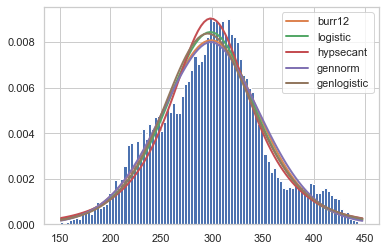

In [109]:
# 'alpha', 'beta', 'betaprime', 'burr', 'burr12', 'chi', 'chi2', 'crystalball', 'erlang', 'exponnorm', 'f', 'fisk', 'foldnorm', 'genlogistic', 'gennorm', 'genextreme', 'gengamma', 'gamma', 'hypsecant', 'logistic', 'powernorm', 'skewnorm'
f2 = Fitter(gfo_data, distributions=['alpha', 'beta', 'betaprime', 'burr', 'burr12', 'chi', 'chi2', 'crystalball', 'erlang', 'exponnorm', 'f', 'fisk', 'foldnorm', 'genlogistic', 'gennorm', 'genextreme', 'gengamma', 'gamma', 'hypsecant', 'logistic', 'powernorm', 'skewnorm'])
f2.fit()
f2.summary()

In [110]:
f2.get_best(method = 'sumsquare_error')

{'burr12': {'c': 8.13747275930745,
  'd': 2.157073351728003,
  'loc': -0.09858259528921806,
  'scale': 336.2249471559824}}

## Maximum likelihood and Least squares method

In [218]:
params_gfo_norm = st.norm.fit(gfo_data)
x = np.linspace(np.min(gfo_data), np.max(gfo_data))

print(f'Maximum likelihood results: {params_gfo_norm}')

Maximum likelihood results: (298.5637605594178, 52.11696586793485)


In [220]:
def loss_for_least_squares_norm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gfo_data, q)
    quantiles_approx = st.norm.ppf(q, *params)
    return quantiles - quantiles_approx

args_ls1 = least_squares(loss_for_least_squares_norm, (1.0, 1.0))['x']
pdf_ls1 = st.norm.pdf(x, *args_ls1)
print(f'Least squares method results: {args_ls1}')

Least squares method results: [298.27720977  51.70354781]


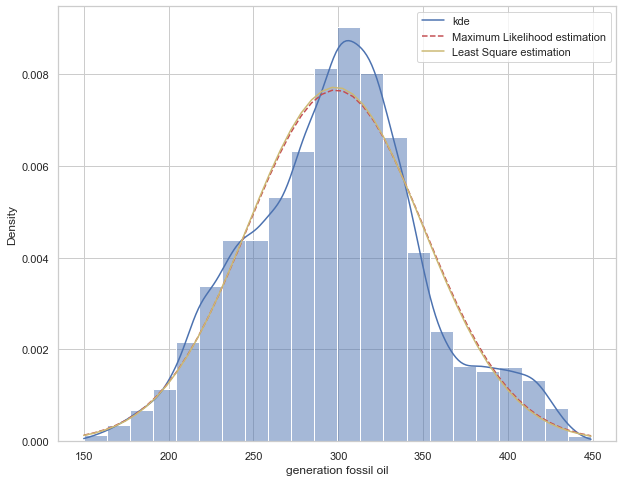

In [113]:
plt.figure(figsize=(10, 8))

sns.histplot(gfo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')

pdf = st.norm.pdf(x, *params_gfo_norm) 

plt.plot(x, pdf, 'r--')
plt.plot(x, pdf_ls1, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

In [221]:
params_gfo_logistic = st.logistic.fit(gfo_data)
x = np.linspace(np.min(gfo_data), np.max(gfo_data))

print(f'Maximum likelihood results: {params_gfo_logistic}')

Maximum likelihood results: (298.24718441318146, 29.610630636102183)


In [222]:
def loss_for_least_squares_logistic(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gfo_data, q)
    quantiles_approx = st.logistic.ppf(q, *params)
    return quantiles - quantiles_approx

args_ls1 = least_squares(loss_for_least_squares_logistic, (1.0, 1.0))['x']
pdf_ls1 = st.logistic.pdf(x, *args_ls1)
print(f'Least squares method results: {args_ls1}')

Least squares method results: [298.68548903  29.42264556]


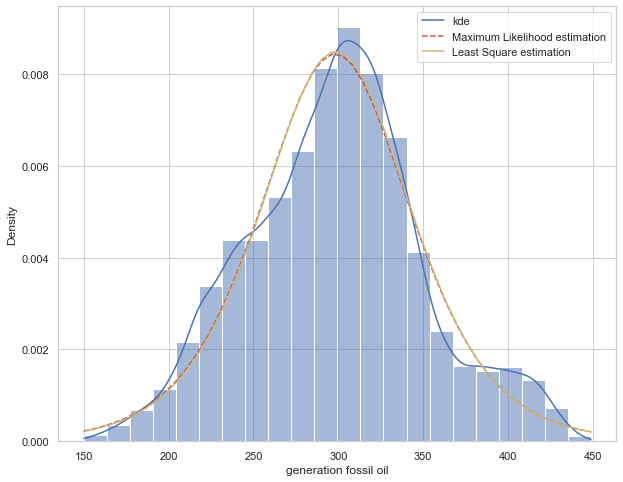

In [116]:
plt.figure(figsize=(10, 8))

sns.histplot(gfo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')

pdf = st.logistic.pdf(x, *params_gfo_logistic) 

plt.plot(x, pdf, 'r--')
plt.plot(x, pdf_ls1, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

## QQ-biplot

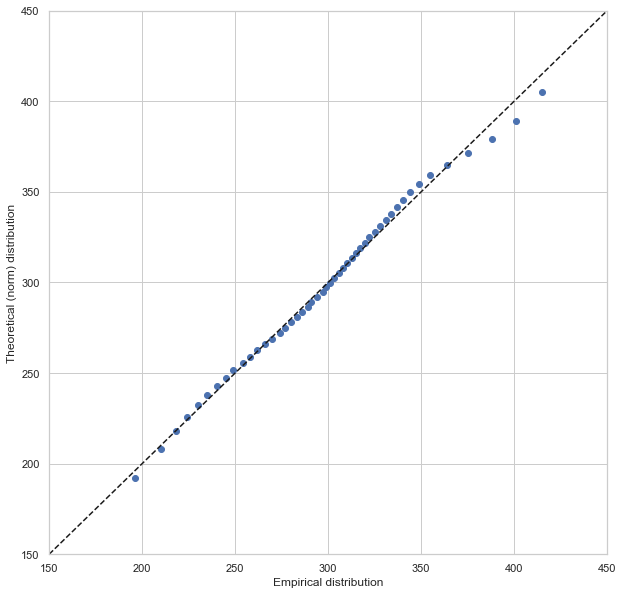

In [117]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gfo_data, percs)
qn_norm = st.norm.ppf(percs / 100.0, *params_gfo_norm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(150, 450)
plt.ylim(150, 450)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

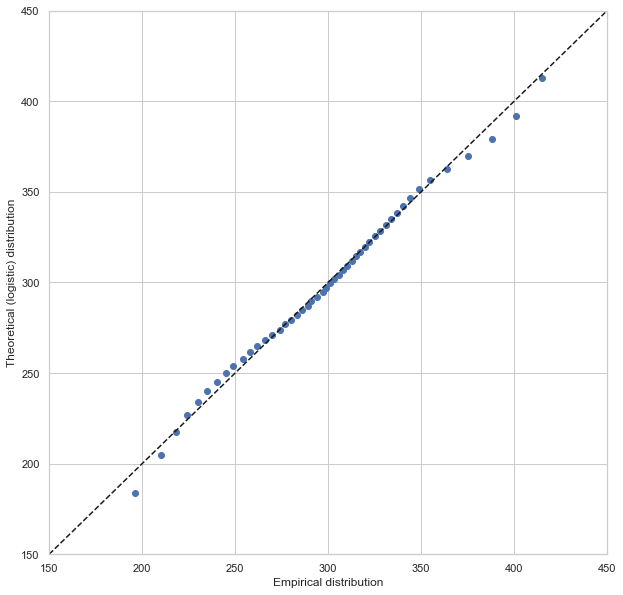

In [118]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gfo_data, percs)
qn_logistic = st.logistic.ppf(percs / 100.0, *params_gfo_logistic)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_logistic, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(150, 450)
plt.ylim(150, 450)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (logistic) distribution')

plt.show()

## Tests

In [119]:
# Calculation of the Kolmogorov-Smirnov test
ks1 = st.kstest(gfo_data, 'norm', params_gfo_norm)
cm1 = scipy.stats.cramervonmises(gfo_data, 'norm', params_gfo_norm)

print(ks1)
print(cm1)

KstestResult(statistic=0.030229872350693743, pvalue=3.114897823187004e-28)
CramerVonMisesResult(statistic=7.3299707088360435, pvalue=4.683901044799654e-10)


In [120]:
# Calculation of the Kolmogorov-Smirnov test
ks1 = st.kstest(gfo_data, 'logistic', params_gfo_logistic)
cm1 = scipy.stats.cramervonmises(gfo_data, 'logistic', params_gfo_logistic)

print(ks1)
print(cm1)

KstestResult(statistic=0.026239204199223792, pvalue=2.2422964343094666e-21)
CramerVonMisesResult(statistic=4.9303942253753235, pvalue=3.820854743707969e-11)


# TRANSFORMATION

In [121]:
cutting_gfo_data = cut_ends(gfo_data)

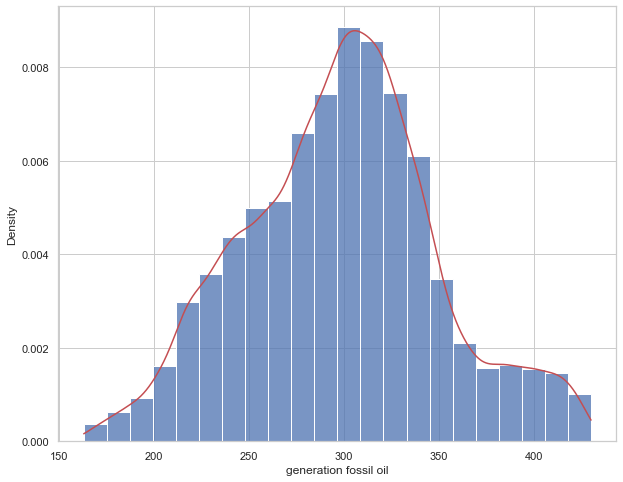

In [122]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_gfo_data)
print(kernel)
min_amount, max_amount = cutting_gfo_data.min(), cutting_gfo_data.max()
x = np.linspace(min_amount, max_amount, len(cutting_gfo_data))
kde_values = kernel(x)

sns.histplot(cutting_gfo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')
plt.plot(x, kde_values, color='r')

,sumsquare_error,aic,bic,kl_div
norm,0.000130,1201.550813,-675612.012798,0.044308
gamma,0.000134,1204.742274,-674546.765635,0.043551
lognorm,0.000134,1205.028782,-674530.408296,0.043562
chi2,0.000142,1206.707331,-672549.900159,0.043985
cauchy,0.000210,1241.719862,-659003.331402,0.067101


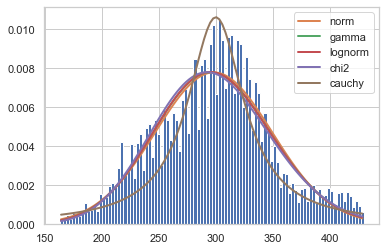

In [123]:
f1_c = Fitter(cutting_gfo_data, distributions=get_common_distributions())

f1_c.fit()
f1_c.summary()

In [124]:
f1_c.get_best(method = 'sumsquare_error')

{'norm': {'loc': 298.23689114791244, 'scale': 51.21998792618229}}

,sumsquare_error,aic,bic,kl_div
burr,0.000114,1211.084687,-680266.332068,0.039444
genlogistic,0.000129,1209.257445,-676044.366344,0.041566
exponnorm,0.000131,1204.407944,-675488.993039,0.043594
skewnorm,0.000133,1204.763928,-674813.964701,0.043399
gamma,0.000134,1204.742274,-674546.765635,0.043551


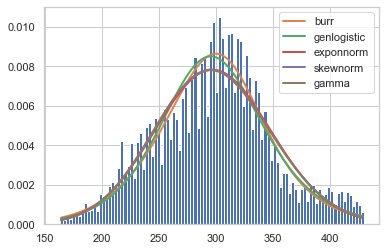

In [125]:
f2_c = Fitter(cutting_gfo_data, distributions=['beta', 'betaprime', 'burr', 'erlang', 'exponnorm', 'exponpow', 'f', 'gamma', 'geninvgauss', 'gausshyper', 'genlogistic', 'gumbel_r', 'invgamma', 'johnsonsb', 'kstwobign', 'maxwell', 'moyal', 'nakagami', 'skewnorm'])
f2_c.fit()
f2_c.summary()

In [126]:
f2_c.get_best(method = 'sumsquare_error')

{'burr': {'c': 12.7939032557355,
  'd': 0.5807721838806436,
  'loc': -1.4193774895679112,
  'scale': 320.21565377011433}}

In [224]:
params_cutting_gfo_norm = st.norm.fit(cutting_gfo_data)
x = np.linspace(np.min(cutting_gfo_data), np.max(cutting_gfo_data))

print(f'Maximum likelihood results: {params_cutting_gfo_norm}')

Maximum likelihood results: (298.23689114791244, 51.21998792618229)


In [225]:
params_cutting_gfo_burr = st.burr.fit(cutting_gfo_data)
x = np.linspace(np.min(cutting_gfo_data), np.max(cutting_gfo_data))

print(f'Maximum likelihood results: {params_cutting_gfo_burr}')

Maximum likelihood results: (12.7939032557355, 0.5807721838806436, -1.4193774895679112, 320.21565377011433)


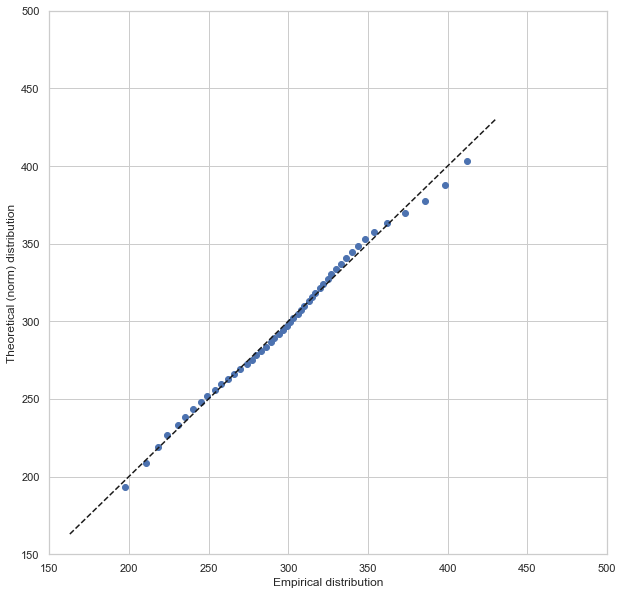

In [129]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_gfo_data, percs)
qn_norm = st.norm.ppf(percs / 100.0, *params_cutting_gfo_norm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(150, 500)
plt.ylim(150, 500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

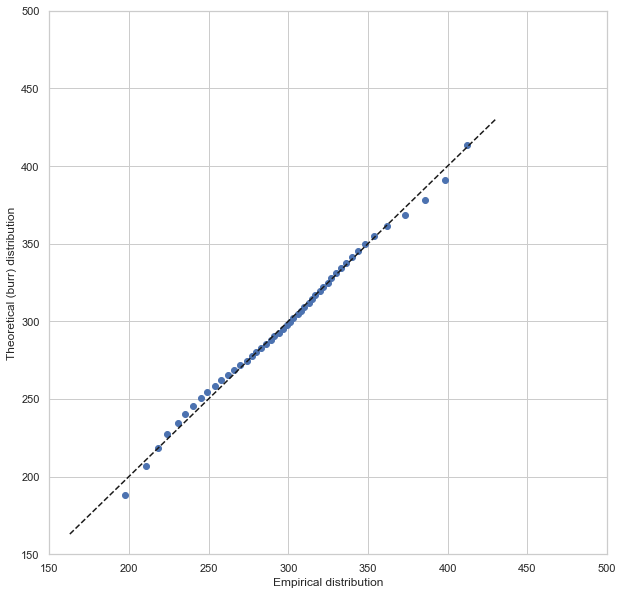

In [130]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_gfo_data, percs)
qn_burr = st.burr.ppf(percs / 100.0, *params_cutting_gfo_burr)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_burr, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(150, 500)
plt.ylim(150, 500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (burr) distribution')

plt.show()

In [226]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
ks1 = st.kstest(cutting_gfo_data, 'norm', params_cutting_gfo_norm)
cm1 = scipy.stats.cramervonmises(cutting_gfo_data, 'norm', params_cutting_gfo_norm)

print(ks1)
print(cm1)

KstestResult(statistic=0.02744458688759288, pvalue=3.240242383882594e-23)
CramerVonMisesResult(statistic=6.645798761037362, pvalue=6.909006700084319e-11)


In [228]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
ks2 = st.kstest(cutting_gfo_data, 'burr', params_cutting_gfo_burr)
cm2 = scipy.stats.cramervonmises(cutting_gfo_data, 'burr', params_cutting_gfo_burr)

print(ks2)
print(cm2)

KstestResult(statistic=0.027983804631886905, pvalue=4.0385954080954915e-24)
CramerVonMisesResult(statistic=4.387965693263697, pvalue=6.900191529268795e-11)


In [180]:
# Yeo Johnson transformation

gfo_data_tr = st.yeojohnson(gfo_data, lmbda=1)

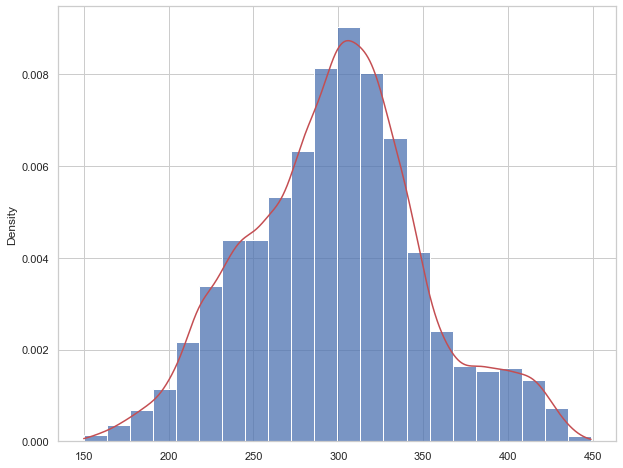

In [181]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(gfo_data_tr)
print(kernel)
min_amount, max_amount = gfo_data_tr.min(), gfo_data_tr.max()
x = np.linspace(min_amount, max_amount, len(gfo_data_tr))
kde_values = kernel(x)

sns.histplot(gfo_data_tr, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')
plt.plot(x, kde_values, color='r')

In [182]:
params_gfo_norm = st.norm.fit(gfo_data_tr)
x = np.linspace(np.min(gfo_data_tr), np.max(gfo_data_tr))

print(f'Maximum likelihood results: {params_gfo_norm}')

Maximum likelihood results: (298.5637605594178, 52.11696586793485)


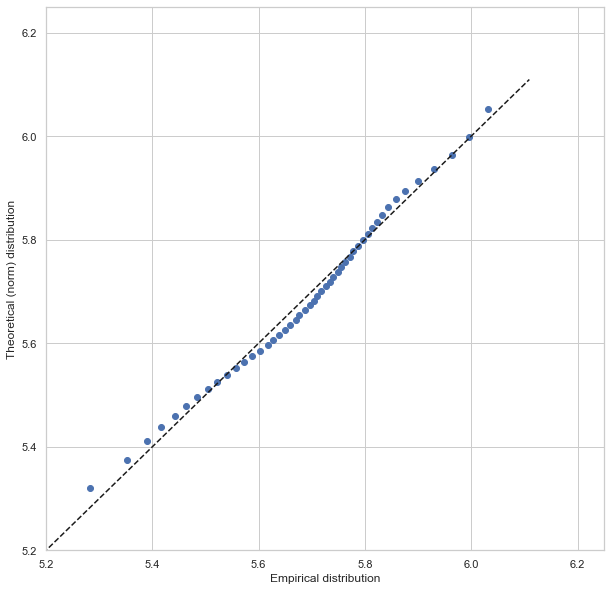

In [136]:
# QQ-plot
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gfo_data_tr, percs)
qn_norm = st.norm.ppf(percs / 100.0, *params_gfo_norm)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(5.2, 6.25)
plt.ylim(5.2, 6.25)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

In [229]:
cutting_gfo_data

9        163.0
10       167.0
11       166.0
12       167.0
13       167.0
         ...  
35059    178.0
35060    174.0
35061    168.0
35062    163.0
35063    163.0
Name: generation fossil oil, Length: 34818, dtype: float64